In [1]:
from CircuitErrorFiltering import CircuitErrorFiltering

## Test Circuit

In [2]:
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

In [3]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)

In [4]:
def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [5]:
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

In [24]:
from qiskit import QuantumCircuit
import math
pi = math.pi

nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)
qc = inverse_qft(qc, nqubits)

qc.draw(fold=-1)

┌─────────┐┌─────────────┐   ┌───┐                                        
q_0: ┤ U2(0,π) ├┤ U(0,0,5π/4) ├─X─┤ H ├─■────────────────────────■─────────────
     ├─────────┤├─────────────┤ │ └───┘ │P(-π/2) ┌───┐           │             
q_1: ┤ U2(0,π) ├┤ U(0,0,5π/2) ├─┼───────■────────┤ H ├─■─────────┼─────────────
     ├─────────┤└┬───────────┬┘ │                └───┘ │P(-π/2)  │P(-π/4) ┌───┐
q_2: ┤ U2(0,π) ├─┤ U(0,0,5π) ├──X──────────────────────■─────────■────────┤ H ├
     └─────────┘ └───────────┘                                            └───┘

In [109]:
transpile(circuits = qc, basis_gates = ['cx', 'id', 'rz', 'sx', 'x']).draw()

global phase: 4.9087
     ┌─────────┐┌────┐┌──────────┐     ┌───┐     ┌─────────┐┌────┐┌─────────┐»
q_0: ┤ Rz(π/2) ├┤ √X ├┤ Rz(-π/4) ├──■──┤ X ├──■──┤ Rz(π/2) ├┤ √X ├┤ Rz(π/4) ├»
     ├─────────┤├────┤└┬────────┬┘  │  └─┬─┘  │  └─────────┘└────┘└─────────┘»
q_1: ┤ Rz(π/2) ├┤ √X ├─┤ Rz(-π) ├───┼────┼────┼──────────────────────────────»
     ├─────────┤├────┤┌┴────────┴┐┌─┴─┐  │  ┌─┴─┐                            »
q_2: ┤ Rz(π/2) ├┤ √X ├┤ Rz(-π/2) ├┤ X ├──■──┤ X ├────────────────────────────»
     └─────────┘└────┘└──────────┘└───┘     └───┘                            »
«                          ┌──────────┐                                      »
«q_0: ──■───────────────■──┤ Rz(-π/8) ├──────────────────────────────────────»
«     ┌─┴─┐┌─────────┐┌─┴─┐├─────────┬┘┌────┐┌─────────┐                     »
«q_1: ┤ X ├┤ Rz(π/4) ├┤ X ├┤ Rz(π/4) ├─┤ √X ├┤ Rz(π/4) ├──■───────────────■──»
«     └───┘└─────────┘└───┘└─────────┘ └────┘└─────────┘┌─┴─┐┌─────────┐┌─┴─┐»
«q_2: ──────────────────────────────────────────────────┤ X ├┤ Rz(π/4) ├┤ X ├»
«                                                       └───┘└─────────┘└───┘»
«                                                                   
«q_0: ──────────────■───────────────■───────────────────────────────
«                   │               │                               
«q_1: ──────────────┼───────────────┼───────────────────────────────
«     ┌──────────┐┌─┴─┐┌─────────┐┌─┴─┐┌──────────┐┌────┐┌─────────┐
«q_2: ┤ Rz(-π/4) ├┤ X ├┤ Rz(π/8) ├┤ X ├┤ Rz(3π/8) ├┤ √X ├┤ Rz(π/2) ├
«     └──────────┘└───┘└─────────┘└───┘└──────────┘└────┘└─────────┘

In [36]:
qc_transpiled = transpile(circuits = qc, basis_gates = ['cx', 'id', 'rz', 'sx', 'x'])
qc_transpiled.measure_all()

# Create noisy simulator backend
sim = AerSimulator()

# Transpile circuit for noisy basis gates
circ = transpile(qc_transpiled, sim)

# Run and get counts
result = sim.run(circ_tnoise, seed_simulator=9, shots=1000).result()

result.get_counts()

{'101': 1000}

In [116]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit_aer.noise import NoiseModel, pauli_error, depolarizing_error
# Example error probabilities
p_gate1 = 0.01

# QuantumError objects
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
#noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["sx"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["rz", "sx", "x"])
#noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

from qiskit_aer import AerSimulator

# Quantum circuit transpile

#qc_transpiled = transpile(circuits = qc, basis_gates = ['cx', 'id', 'rz', 'sx', 'x'])

# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)

# Transpile circuit for noisy basis gates
circ_tnoise1 = transpile(qc, sim_noise)
circ_tnoise1.measure_all()

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise1, seed_simulator=9, shots=1000).result()
result_bit_flip.get_counts()

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'rz', 'sx']
  All-qubits errors: ['rz', 'sx', 'x']


{'101': 804,
 '011': 30,
 '001': 65,
 '010': 4,
 '111': 28,
 '110': 24,
 '100': 37,
 '000': 8}

In [117]:
# Transpile circuit for noisy basis gates
circ_tnoise2 = transpile(qc, sim_noise)
EF_qc = CircuitErrorFiltering(circ_tnoise2, 0)

In [118]:
__shots = 1000
__num_qubits = 3 + 2
#__backend_sim = Aer.get_backend('qasm_simulator')
__job_sim = sim_noise.run(EF_qc.SingleQubitBitFlip(), seed_simulator=9, shots=__shots)
__counts = __job_sim.result().get_counts()

# Parameter setting
__counts_postprocess = {}

# bitstrings
__format_bitstring = '{0:0' + str(3) + 'b}'
__bitstring_keys = [__format_bitstring.format(ii) for ii in range(2**3)]
__counts_postprocess = {key: 0 for key, value in dict.fromkeys(__bitstring_keys).items()}

for result_string in __counts:
    if result_string[0:2] == '00':
        __counts_postprocess[result_string[2:__num_qubits]] = __counts[result_string]

print('Probability of post-selection:', sum(__counts_postprocess.values())/__shots)
print('Post processed counts:', __counts_postprocess)

Probability of post-selection: 0.948
Post processed counts: {'000': 4, '001': 53, '010': 3, '011': 29, '100': 12, '101': 820, '110': 6, '111': 21}


In [129]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit_aer.noise import NoiseModel, pauli_error, depolarizing_error
# Example error probabilities
error1 = depolarizing_error(0.01, 1)
error2 = depolarizing_error(0.01, 2)

# Add errors to noise model
noise_model = NoiseModel()
#noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["sx"])
noise_model.add_all_qubit_quantum_error(error1, ["rz", "sx", "x"])
noise_model.add_all_qubit_quantum_error(error2, ["cx"])

print(noise_model)

from qiskit_aer import AerSimulator

# Quantum circuit transpile

#qc_transpiled = transpile(circuits = qc, basis_gates = ['cx', 'id', 'rz', 'sx', 'x'])

# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_model)

# Transpile circuit for noisy basis gates
circ_tnoise1 = transpile(qc, sim_noise)
circ_tnoise1.measure_all()

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise1, seed_simulator=9, shots=1000).result()
result_bit_flip.get_counts()

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'cx', 'rz', 'sx']
  All-qubits errors: ['rz', 'sx', 'x', 'cx']


{'101': 817,
 '011': 21,
 '001': 59,
 '010': 10,
 '111': 20,
 '110': 24,
 '100': 35,
 '000': 14}

In [130]:
# Transpile circuit for noisy basis gates
circ_tnoise2 = transpile(qc, sim_noise)
EF_qc = CircuitErrorFiltering(circ_tnoise2, 0)

In [131]:
__shots = 1000
__num_qubits = 3 + 2
#__backend_sim = Aer.get_backend('qasm_simulator')
__job_sim = sim_noise.run(EF_qc.SingleQubitBitFlip(), seed_simulator=9, shots=__shots)
__counts = __job_sim.result().get_counts()

# Parameter setting
__counts_postprocess = {}

# bitstrings
__format_bitstring = '{0:0' + str(3) + 'b}'
__bitstring_keys = [__format_bitstring.format(ii) for ii in range(2**3)]
__counts_postprocess = {key: 0 for key, value in dict.fromkeys(__bitstring_keys).items()}

for result_string in __counts:
    if result_string[0:2] == '00':
        __counts_postprocess[result_string[2:__num_qubits]] = __counts[result_string]

print('Probability of post-selection:', sum(__counts_postprocess.values())/__shots)
print('Post processed counts:', __counts_postprocess)

Probability of post-selection: 0.912
Post processed counts: {'000': 7, '001': 53, '010': 7, '011': 20, '100': 16, '101': 773, '110': 11, '111': 25}


In [173]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit_aer.noise import NoiseModel, pauli_error, depolarizing_error
# Example error probabilities
error1 = depolarizing_error(0.01, 1)
error2 = depolarizing_error(0.01, 2)

# Add errors to noise model
noise_model = NoiseModel()
#noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["sx"])
noise_model.add_quantum_error(error1, ["rz", "sx", "x"], [0])
noise_model.add_quantum_error(error1, ["rz", "sx", "x"], [1])
noise_model.add_quantum_error(error1, ["rz", "sx", "x"], [2])
noise_model.add_quantum_error(error2, ["cx"], [0,1])
noise_model.add_quantum_error(error2, ["cx"], [0,2])
noise_model.add_quantum_error(error2, ["cx"], [1,2])
noise_model.add_quantum_error(error2, ["cx"], [2,0])

print(noise_model)

from qiskit_aer import AerSimulator

# Quantum circuit transpile

#qc_transpiled = transpile(circuits = qc, basis_gates = ['cx', 'id', 'rz', 'sx', 'x'])

# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_model)

# Transpile circuit for noisy basis gates
circ_tnoise1 = transpile(qc, sim_noise)
circ_tnoise1.measure_all()

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise1, seed_simulator=9, shots=1000).result()
result_bit_flip.get_counts()

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['x', 'cx', 'rz', 'sx']
  Qubits with noise: [0, 1, 2]
  Specific qubit errors: [('rz', (0,)), ('rz', (1,)), ('rz', (2,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (1, 2)), ('cx', (2, 0))]


{'101': 817,
 '011': 21,
 '001': 59,
 '010': 10,
 '111': 20,
 '110': 24,
 '100': 35,
 '000': 14}

In [174]:
# Transpile circuit for noisy basis gates
circ_tnoise2 = transpile(qc, sim_noise)
EF_qc = CircuitErrorFiltering(circ_tnoise2, 0)

In [175]:
__shots = 1000
__num_qubits = 3 + 2
#__backend_sim = Aer.get_backend('qasm_simulator')
__job_sim = sim_noise.run(EF_qc.SingleQubitBitFlip(), seed_simulator=9, shots=__shots)
__counts = __job_sim.result().get_counts()

# Parameter setting
__counts_postprocess = {}

# bitstrings
__format_bitstring = '{0:0' + str(3) + 'b}'
__bitstring_keys = [__format_bitstring.format(ii) for ii in range(2**3)]
__counts_postprocess = {key: 0 for key, value in dict.fromkeys(__bitstring_keys).items()}

for result_string in __counts:
    if result_string[0:2] == '00':
        __counts_postprocess[result_string[2:__num_qubits]] = __counts[result_string]

print('Probability of post-selection:', sum(__counts_postprocess.values())/__shots)
print('Post processed counts:', __counts_postprocess)

Probability of post-selection: 0.944
Post processed counts: {'000': 5, '001': 50, '010': 4, '011': 24, '100': 10, '101': 828, '110': 5, '111': 18}


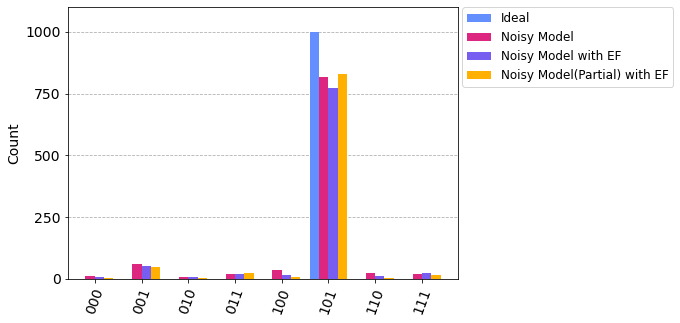

In [4]:
from qiskit.visualization import plot_histogram

ideal_result = {'000': 0, '001': 0, '010': 0, '011': 0, '100': 0, '101': 1000, '110': 0, '111': 0}
noisy_model = {'101': 817,
 '011': 21,
 '001': 59,
 '010': 10,
 '111': 20,
 '110': 24,
 '100': 35,
 '000': 14}
error_filtered_anoise = {'000': 7, '001': 53, '010': 7, '011': 20, '100': 16, '101': 773, '110': 11, '111': 25}
error_filtered_pnoise = {'000': 5, '001': 50, '010': 4, '011': 24, '100': 10, '101': 828, '110': 5, '111': 18}

#title_qas = ""
legend = ["Ideal", "Noisy Model", "Noisy Model with EF", "Noisy Model(Partial) with EF"]
plot_histogram([ideal_result, noisy_model, error_filtered_anoise, error_filtered_pnoise], 
               legend = legend, bar_labels=False)